## Домашнее задание №4

### Бабушкина Татьяна

### Реализация алгоритма t-SNE

In [11]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.manifold.t_sne import _joint_probabilities
from matplotlib import pyplot as plt
import seaborn as sns

/Users/a18860104/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("Paired", 10)

In [13]:
X, y = load_digits(return_X_y=True)# на примере чисел

In [14]:
EPS = np.finfo(np.double).eps
n_components = 2
perplexity = 30

In [15]:
# Функция градиентного спуска обновляет значения встраивания, минимизируя расхождение К-Л
# Мы останавливаемся преждевременно, когда либо норма градиента ниже порога, 
# либо когда мы достигаем максимального количества итераций без какого-либо прогресса
def gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_increase=0.01,
                      min_grad_norm=1e-7):
    
    point = p0.copy().ravel()
    update = np.zeros_like(point)
    increase = np.ones_like(point)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        error, grad = obj_func(point, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        
        increase[inc] += 0.2
        increase[dec] *= 0.8
        np.clip(increase, min_increase, np.inf, out=increase)
        grad *= increase
        update = momentum * update - learning_rate * grad
        point += update
        
        print("Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      % (i + 1, error, grad_norm))
        
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break
            
    return point

In [16]:
# вычисление ошибки в форме расхождения К-Л и градиента
def divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    
    Q = np.maximum(dist / (2.0 * np.sum(dist)), EPS)
    
    # "дивергенция" Кульбака-Лейблера P и Q
    divergence = 2.0 * np.dot(P, np.log(np.maximum(P, EPS) / Q))
    
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    
    return divergence, grad

In [17]:
def our_tsne(P, degrees_of_freedom, n_samples, X_embedded):
    
    params = X_embedded.ravel()
    obj_func = divergence
    params = gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
    X_embedded = params.reshape(n_samples, n_components)
    
    return X_embedded

In [18]:
def fit(X):
    n_samples = X.shape[0]
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    degrees_of_freedom = max(n_components - 1, 1)
    
    return our_tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)


In [19]:
# обучаем
X_embedded = fit(X)

Iteration 1: error = 4.0229677, gradient norm = 0.0000052
Iteration 2: error = 4.0229676, gradient norm = 0.0000051
Iteration 3: error = 4.0229676, gradient norm = 0.0000063
Iteration 4: error = 4.0229676, gradient norm = 0.0000098
Iteration 5: error = 4.0229676, gradient norm = 0.0000168
Iteration 6: error = 4.0229674, gradient norm = 0.0000311
Iteration 7: error = 4.0229665, gradient norm = 0.0000614
Iteration 8: error = 4.0229630, gradient norm = 0.0001283
Iteration 9: error = 4.0229456, gradient norm = 0.0002825
Iteration 10: error = 4.0228532, gradient norm = 0.0006523
Iteration 11: error = 4.0223144, gradient norm = 0.0015716
Iteration 12: error = 4.0189358, gradient norm = 0.0038897
Iteration 13: error = 3.9974894, gradient norm = 0.0091834
Iteration 14: error = 3.8892383, gradient norm = 0.0163704
Iteration 15: error = 3.6006760, gradient norm = 0.0182913
Iteration 16: error = 3.2233052, gradient norm = 0.0151265
Iteration 17: error = 2.8912997, gradient norm = 0.0118165
Iterat

Iteration 141: error = 0.9467287, gradient norm = 0.0004463
Iteration 142: error = 0.9453928, gradient norm = 0.0003756
Iteration 143: error = 0.9440831, gradient norm = 0.0004337
Iteration 144: error = 0.9427739, gradient norm = 0.0003783
Iteration 145: error = 0.9414843, gradient norm = 0.0003948
Iteration 146: error = 0.9402027, gradient norm = 0.0003760
Iteration 147: error = 0.9389379, gradient norm = 0.0004099
Iteration 148: error = 0.9376774, gradient norm = 0.0003704
Iteration 149: error = 0.9364303, gradient norm = 0.0003678
Iteration 150: error = 0.9351955, gradient norm = 0.0003600
Iteration 151: error = 0.9339764, gradient norm = 0.0003692
Iteration 152: error = 0.9327685, gradient norm = 0.0003550
Iteration 153: error = 0.9315789, gradient norm = 0.0003608
Iteration 154: error = 0.9304052, gradient norm = 0.0003512
Iteration 155: error = 0.9292456, gradient norm = 0.0003483
Iteration 156: error = 0.9281010, gradient norm = 0.0003306
Iteration 157: error = 0.9269753, gradie

Iteration 278: error = 0.8388501, gradient norm = 0.0002752
Iteration 279: error = 0.8383372, gradient norm = 0.0002886
Iteration 280: error = 0.8378365, gradient norm = 0.0002851
Iteration 281: error = 0.8373501, gradient norm = 0.0002642
Iteration 282: error = 0.8368850, gradient norm = 0.0002524
Iteration 283: error = 0.8364424, gradient norm = 0.0002376
Iteration 284: error = 0.8360207, gradient norm = 0.0002191
Iteration 285: error = 0.8356206, gradient norm = 0.0002065
Iteration 286: error = 0.8352395, gradient norm = 0.0002102
Iteration 287: error = 0.8348717, gradient norm = 0.0002063
Iteration 288: error = 0.8345159, gradient norm = 0.0002067
Iteration 289: error = 0.8341689, gradient norm = 0.0001980
Iteration 290: error = 0.8338303, gradient norm = 0.0001919
Iteration 291: error = 0.8334997, gradient norm = 0.0001869
Iteration 292: error = 0.8331770, gradient norm = 0.0001852
Iteration 293: error = 0.8328607, gradient norm = 0.0001733
Iteration 294: error = 0.8325519, gradie

Iteration 416: error = 0.8075023, gradient norm = 0.0001097
Iteration 417: error = 0.8073452, gradient norm = 0.0001129
Iteration 418: error = 0.8071877, gradient norm = 0.0001092
Iteration 419: error = 0.8070301, gradient norm = 0.0001184
Iteration 420: error = 0.8068715, gradient norm = 0.0001275
Iteration 421: error = 0.8067112, gradient norm = 0.0001155
Iteration 422: error = 0.8065500, gradient norm = 0.0001029
Iteration 423: error = 0.8063882, gradient norm = 0.0001139
Iteration 424: error = 0.8062246, gradient norm = 0.0001236
Iteration 425: error = 0.8060586, gradient norm = 0.0001165
Iteration 426: error = 0.8058905, gradient norm = 0.0001153
Iteration 427: error = 0.8057200, gradient norm = 0.0001187
Iteration 428: error = 0.8055472, gradient norm = 0.0001527
Iteration 429: error = 0.8053713, gradient norm = 0.0002064
Iteration 430: error = 0.8051858, gradient norm = 0.0001653
Iteration 431: error = 0.8049942, gradient norm = 0.0001327
Iteration 432: error = 0.8047967, gradie

Iteration 553: error = 0.7810286, gradient norm = 0.0000985
Iteration 554: error = 0.7808773, gradient norm = 0.0001009
Iteration 555: error = 0.7807260, gradient norm = 0.0001001
Iteration 556: error = 0.7805742, gradient norm = 0.0001036
Iteration 557: error = 0.7804215, gradient norm = 0.0001030
Iteration 558: error = 0.7802678, gradient norm = 0.0001122
Iteration 559: error = 0.7801127, gradient norm = 0.0001244
Iteration 560: error = 0.7799556, gradient norm = 0.0001247
Iteration 561: error = 0.7797960, gradient norm = 0.0000997
Iteration 562: error = 0.7796355, gradient norm = 0.0001127
Iteration 563: error = 0.7794722, gradient norm = 0.0001103
Iteration 564: error = 0.7793065, gradient norm = 0.0001063
Iteration 565: error = 0.7791385, gradient norm = 0.0001076
Iteration 566: error = 0.7789678, gradient norm = 0.0000995
Iteration 567: error = 0.7787953, gradient norm = 0.0001063
Iteration 568: error = 0.7786204, gradient norm = 0.0001043
Iteration 569: error = 0.7784435, gradie

Iteration 690: error = 0.7643394, gradient norm = 0.0000818
Iteration 691: error = 0.7642552, gradient norm = 0.0000842
Iteration 692: error = 0.7641709, gradient norm = 0.0000799
Iteration 693: error = 0.7640870, gradient norm = 0.0000762
Iteration 694: error = 0.7640036, gradient norm = 0.0000802
Iteration 695: error = 0.7639203, gradient norm = 0.0000731
Iteration 696: error = 0.7638377, gradient norm = 0.0000793
Iteration 697: error = 0.7637552, gradient norm = 0.0000760
Iteration 698: error = 0.7636732, gradient norm = 0.0000795
Iteration 699: error = 0.7635914, gradient norm = 0.0000762
Iteration 700: error = 0.7635098, gradient norm = 0.0000710
Iteration 701: error = 0.7634287, gradient norm = 0.0000702
Iteration 702: error = 0.7633479, gradient norm = 0.0000749
Iteration 703: error = 0.7632670, gradient norm = 0.0000692
Iteration 704: error = 0.7631865, gradient norm = 0.0000729
Iteration 705: error = 0.7631059, gradient norm = 0.0000720
Iteration 706: error = 0.7630254, gradie

Iteration 827: error = 0.7523100, gradient norm = 0.0000759
Iteration 828: error = 0.7522089, gradient norm = 0.0000770
Iteration 829: error = 0.7521065, gradient norm = 0.0000814
Iteration 830: error = 0.7520028, gradient norm = 0.0000864
Iteration 831: error = 0.7518971, gradient norm = 0.0000802
Iteration 832: error = 0.7517899, gradient norm = 0.0000746
Iteration 833: error = 0.7516811, gradient norm = 0.0000788
Iteration 834: error = 0.7515701, gradient norm = 0.0000805
Iteration 835: error = 0.7514568, gradient norm = 0.0000763
Iteration 836: error = 0.7513412, gradient norm = 0.0000791
Iteration 837: error = 0.7512224, gradient norm = 0.0000815
Iteration 838: error = 0.7510997, gradient norm = 0.0000818
Iteration 839: error = 0.7509723, gradient norm = 0.0000883
Iteration 840: error = 0.7508383, gradient norm = 0.0000925
Iteration 841: error = 0.7506979, gradient norm = 0.0000978
Iteration 842: error = 0.7505553, gradient norm = 0.0001057
Iteration 843: error = 0.7504130, gradie

Iteration 965: error = 0.7216699, gradient norm = 0.0000778
Iteration 966: error = 0.7215671, gradient norm = 0.0000762
Iteration 967: error = 0.7214633, gradient norm = 0.0000781
Iteration 968: error = 0.7213584, gradient norm = 0.0000807
Iteration 969: error = 0.7212523, gradient norm = 0.0000809
Iteration 970: error = 0.7211452, gradient norm = 0.0000762
Iteration 971: error = 0.7210372, gradient norm = 0.0000760
Iteration 972: error = 0.7209282, gradient norm = 0.0000760
Iteration 973: error = 0.7208182, gradient norm = 0.0000778
Iteration 974: error = 0.7207075, gradient norm = 0.0000821
Iteration 975: error = 0.7205957, gradient norm = 0.0000804
Iteration 976: error = 0.7204828, gradient norm = 0.0000771
Iteration 977: error = 0.7203691, gradient norm = 0.0000756
Iteration 978: error = 0.7202546, gradient norm = 0.0000808
Iteration 979: error = 0.7201393, gradient norm = 0.0000811
Iteration 980: error = 0.7200231, gradient norm = 0.0000764
Iteration 981: error = 0.7199064, gradie

/Users/a18860104/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

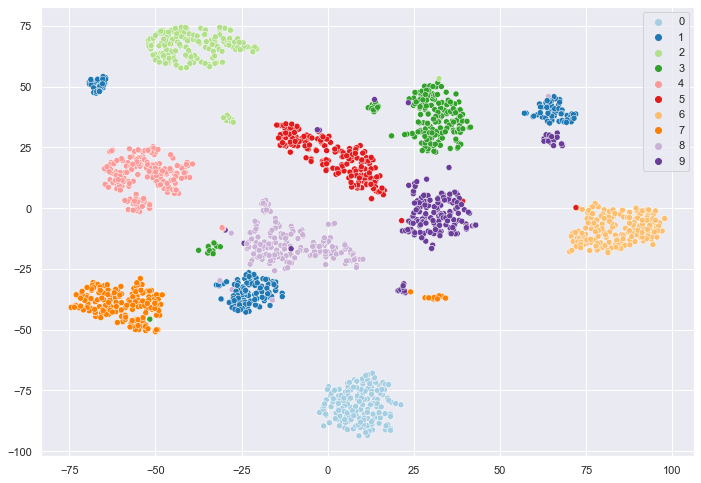

In [20]:
# визуализируем
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

### Теперь сделаем тоже самое, используя готовую t-SNE из библиотеки scikit-learn

In [21]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X)

/Users/a18860104/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

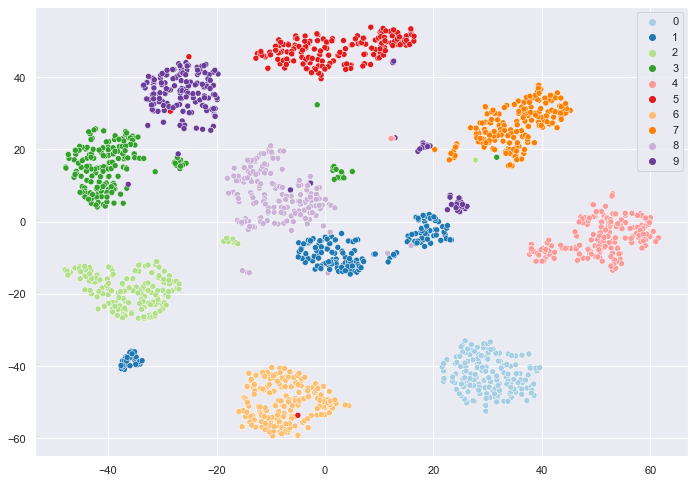

In [22]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)